In [1]:
#import important libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
# Keras API
from tensorflow import keras
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,BatchNormalization,Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, Activation, Flatten
#from tensorflow.keras.layers import Conv2D, MaxPooling2D,Concatenate
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix 
import pickle
import time
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
#load the dataset from pickled files
pickle_in = open("X_Color.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("W_Color.pickle","rb")
W = pickle.load(pickle_in)
W=np.asarray(W)

pickle_in = open("Y_Color.pickle","rb")
y = pickle.load(pickle_in)
y = to_categorical(y)

In [3]:
print(type(X))
print(X.shape)
print(W.shape)
print(y.shape)

<class 'numpy.ndarray'>
(8068, 64, 64, 3)
(8068,)
(8068, 5)


In [4]:
#split into train and test datasets
#X.reshape((8181,3),64,64,1)
X_train,X_test,W_train,W_test,y_train,y_test=train_test_split(X,W,y,train_size=0.75,test_size=0.25,random_state=123)
print(X_test.shape)
print(W_test.shape)
print(y_test.shape)

(2017, 64, 64, 3)
(2017,)
(2017, 5)


In [5]:
from tensorflow.keras.utils import plot_model
from keras.layers.merge import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 60, 60, 128)  9728        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 30, 30, 128)  0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 30, 30, 128)  0           max_pooling2d_3[0][0]            
_______________________________________________________________________________________

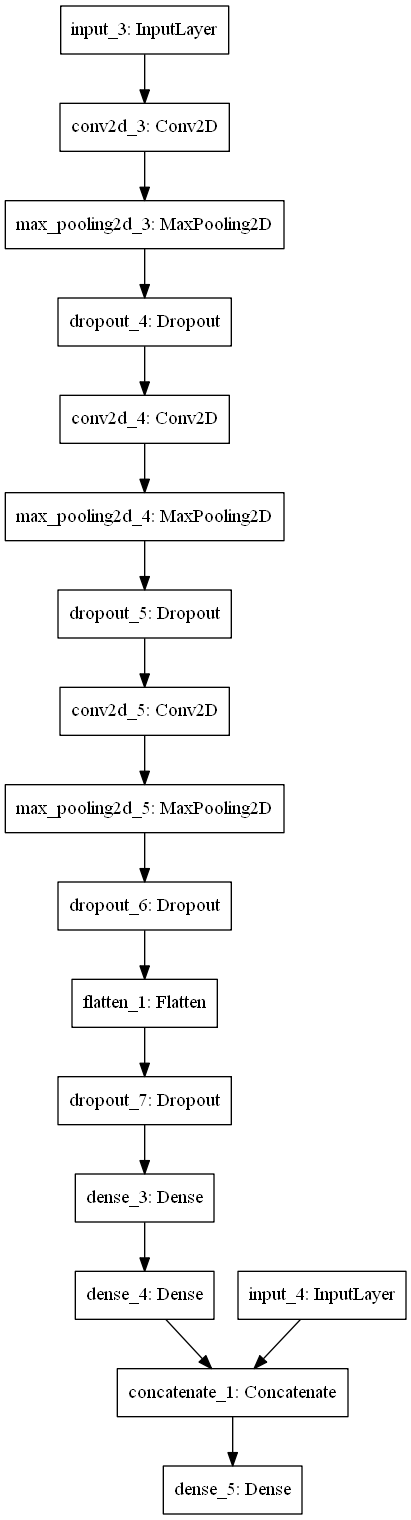

In [9]:
#Build the model
visible1 = Input(shape=(64,64,3))

# first feature extractor

conv1 = Conv2D(128, kernel_size=(5,5), activation='relu')(visible1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
dropout1=Dropout(0.2)(pool1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout1)
#conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout2=Dropout(0.2)(pool2)

conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout2)
#conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout3=Dropout(0.2)(pool3)


flat1 = Flatten()(dropout3)
dropout4=Dropout(0.5)(flat1)
#### New entry to try concatentation
flat2 = Input(shape=(1))



#hidden1 = Dense(64, activation='relu')(merge)
hidden1 = Dense(64, activation='relu')(dropout4)
hidden2 = Dense(16, activation='relu')(hidden1)

hidden3 = Concatenate()([hidden2, flat2])
#regress=

## 

#output = Dense(5, activation='softmax')(hidden2)

output = Dense(5, activation='softmax')(hidden3)

model = Model(inputs=(visible1,flat2), outputs=output)
#model = Model(inputs=(visible1), outputs=output)
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [10]:
#Compile models with hyperparameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],
             )

In [11]:
#Run model with 1000 epochs
import time
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
start = time.perf_counter()
print(y_train.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_color_weights.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit((X_train,W_train), y_train, batch_size=64, epochs=1000, validation_split=0.2,shuffle=1, callbacks=[es, mc], class_weight=None)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(6051, 5)
Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 3.5909 - accuracy: 0.4643 - precision_1: 0.4974 - recall_1: 0.3360
Epoch 00001: val_accuracy improved from -inf to 0.27993, saving model to best_model_color_weights.h5
76/76 [==============================] - 62s 815ms/step - loss: 3.5909 - accuracy: 0.4643 - precision_1: 0.4974 - recall_1: 0.3360 - val_loss: 1.4365 - val_accuracy: 0.2799 - val_precision_1: 0.2601 - val_recall_1: 0.1115
Epoch 2/1000
76/76 [==============================] - ETA: 0s - loss: 0.8185 - accuracy: 0.6917 - precision_1: 0.7715 - recall_1: 0.5866
Epoch 00002: val_accuracy improved from 0.27993 to 0.67382, saving model to best_model_color_weights.h5
76/76 [==============================] - 70s 922ms/step - loss: 0.8185 - accuracy: 0.6917 - precision_1: 0.7715 - recall_1: 0.5866 - val_loss: 0.9591 - val_accuracy: 0.6738 - val_precision_1: 0.6528 - val_recall_1: 0.4286
Epoch 3/1000
76/76 [==============================] - ETA: 0s - los

76/76 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9628 - precision_1: 0.9650 - recall_1: 0.9616
Epoch 00038: val_accuracy did not improve from 0.96780
76/76 [==============================] - 70s 925ms/step - loss: 0.1078 - accuracy: 0.9628 - precision_1: 0.9650 - recall_1: 0.9616 - val_loss: 0.1194 - val_accuracy: 0.9595 - val_precision_1: 0.9650 - val_recall_1: 0.9554
Epoch 39/1000
76/76 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.9560 - precision_1: 0.9589 - recall_1: 0.9539
Epoch 00039: val_accuracy improved from 0.96780 to 0.97110, saving model to best_model_color_weights.h5
76/76 [==============================] - 70s 917ms/step - loss: 0.1320 - accuracy: 0.9560 - precision_1: 0.9589 - recall_1: 0.9539 - val_loss: 0.1008 - val_accuracy: 0.9711 - val_precision_1: 0.9751 - val_recall_1: 0.9694
Epoch 40/1000
76/76 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9570 - precision_1: 0.9595 - recall_1: 0.95

Epoch 58/1000
76/76 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9653 - precision_1: 0.9674 - recall_1: 0.9636
Epoch 00058: val_accuracy did not improve from 0.97358
76/76 [==============================] - 70s 923ms/step - loss: 0.0988 - accuracy: 0.9653 - precision_1: 0.9674 - recall_1: 0.9636 - val_loss: 0.1191 - val_accuracy: 0.9628 - val_precision_1: 0.9683 - val_recall_1: 0.9571
Epoch 59/1000
76/76 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9684 - precision_1: 0.9707 - recall_1: 0.9657
Epoch 00059: val_accuracy did not improve from 0.97358
76/76 [==============================] - 70s 917ms/step - loss: 0.0951 - accuracy: 0.9684 - precision_1: 0.9707 - recall_1: 0.9657 - val_loss: 0.1391 - val_accuracy: 0.9571 - val_precision_1: 0.9577 - val_recall_1: 0.9546
Epoch 60/1000
76/76 [==============================] - ETA: 0s - loss: 0.0912 - accuracy: 0.9709 - precision_1: 0.9712 - recall_1: 0.9688
Epoch 00060: val_accuracy did no

Epoch 78/1000
76/76 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9715 - precision_1: 0.9729 - recall_1: 0.9702
Epoch 00078: val_accuracy did not improve from 0.97605
76/76 [==============================] - 70s 919ms/step - loss: 0.0840 - accuracy: 0.9715 - precision_1: 0.9729 - recall_1: 0.9702 - val_loss: 0.1278 - val_accuracy: 0.9587 - val_precision_1: 0.9674 - val_recall_1: 0.9554
Epoch 79/1000
76/76 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9800 - precision_1: 0.9806 - recall_1: 0.9791
Epoch 00079: val_accuracy did not improve from 0.97605
76/76 [==============================] - 70s 926ms/step - loss: 0.0635 - accuracy: 0.9800 - precision_1: 0.9806 - recall_1: 0.9791 - val_loss: 0.1195 - val_accuracy: 0.9645 - val_precision_1: 0.9668 - val_recall_1: 0.9620
Epoch 80/1000
76/76 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9826 - precision_1: 0.9837 - recall_1: 0.9820
Epoch 00080: val_accuracy did no

Epoch 98/1000
76/76 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9756 - precision_1: 0.9768 - recall_1: 0.9738
Epoch 00098: val_accuracy did not improve from 0.98018
76/76 [==============================] - 70s 915ms/step - loss: 0.0668 - accuracy: 0.9756 - precision_1: 0.9768 - recall_1: 0.9738 - val_loss: 0.1118 - val_accuracy: 0.9694 - val_precision_1: 0.9725 - val_recall_1: 0.9653
Epoch 99/1000
76/76 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.9758 - precision_1: 0.9774 - recall_1: 0.9752
Epoch 00099: val_accuracy did not improve from 0.98018
76/76 [==============================] - 70s 920ms/step - loss: 0.0632 - accuracy: 0.9758 - precision_1: 0.9774 - recall_1: 0.9752 - val_loss: 0.0926 - val_accuracy: 0.9736 - val_precision_1: 0.9743 - val_recall_1: 0.9703
Epoch 100/1000
76/76 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9804 - precision_1: 0.9806 - recall_1: 0.9793
Epoch 00100: val_accuracy did n

Epoch 118/1000
76/76 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9787 - precision_1: 0.9797 - recall_1: 0.9775
Epoch 00118: val_accuracy did not improve from 0.98183
76/76 [==============================] - 70s 921ms/step - loss: 0.0631 - accuracy: 0.9787 - precision_1: 0.9797 - recall_1: 0.9775 - val_loss: 0.0990 - val_accuracy: 0.9727 - val_precision_1: 0.9735 - val_recall_1: 0.9711
Epoch 119/1000
76/76 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9820 - precision_1: 0.9832 - recall_1: 0.9812
Epoch 00119: val_accuracy did not improve from 0.98183
76/76 [==============================] - 70s 916ms/step - loss: 0.0522 - accuracy: 0.9820 - precision_1: 0.9832 - recall_1: 0.9812 - val_loss: 0.0957 - val_accuracy: 0.9752 - val_precision_1: 0.9768 - val_recall_1: 0.9752
Epoch 120/1000
76/76 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9839 - precision_1: 0.9841 - recall_1: 0.9837
Epoch 00120: val_accuracy did

Epoch 138/1000
76/76 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.9810 - precision_1: 0.9810 - recall_1: 0.9808
Epoch 00138: val_accuracy did not improve from 0.98183
76/76 [==============================] - 70s 922ms/step - loss: 0.0585 - accuracy: 0.9810 - precision_1: 0.9810 - recall_1: 0.9808 - val_loss: 0.0934 - val_accuracy: 0.9761 - val_precision_1: 0.9784 - val_recall_1: 0.9744
Epoch 139/1000
76/76 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9810 - precision_1: 0.9824 - recall_1: 0.9802
Epoch 00139: val_accuracy did not improve from 0.98183
76/76 [==============================] - 70s 916ms/step - loss: 0.0579 - accuracy: 0.9810 - precision_1: 0.9824 - recall_1: 0.9802 - val_loss: 0.1032 - val_accuracy: 0.9736 - val_precision_1: 0.9744 - val_recall_1: 0.9736
Epoch 140/1000
76/76 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9853 - precision_1: 0.9855 - recall_1: 0.9847
Epoch 00140: val_accuracy did

Epoch 158/1000
76/76 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9816 - precision_1: 0.9824 - recall_1: 0.9808
Epoch 00158: val_accuracy did not improve from 0.98348
76/76 [==============================] - 71s 935ms/step - loss: 0.0533 - accuracy: 0.9816 - precision_1: 0.9824 - recall_1: 0.9808 - val_loss: 0.1297 - val_accuracy: 0.9761 - val_precision_1: 0.9792 - val_recall_1: 0.9727
Epoch 159/1000
76/76 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9855 - precision_1: 0.9859 - recall_1: 0.9851
Epoch 00159: val_accuracy did not improve from 0.98348
76/76 [==============================] - 71s 928ms/step - loss: 0.0573 - accuracy: 0.9855 - precision_1: 0.9859 - recall_1: 0.9851 - val_loss: 0.0904 - val_accuracy: 0.9761 - val_precision_1: 0.9784 - val_recall_1: 0.9719
Epoch 160/1000
76/76 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9886 - precision_1: 0.9890 - recall_1: 0.9882
Epoch 00160: val_accuracy did

Epoch 178/1000
76/76 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9874 - precision_1: 0.9876 - recall_1: 0.9872
Epoch 00178: val_accuracy did not improve from 0.98348
76/76 [==============================] - 71s 928ms/step - loss: 0.0388 - accuracy: 0.9874 - precision_1: 0.9876 - recall_1: 0.9872 - val_loss: 0.1151 - val_accuracy: 0.9694 - val_precision_1: 0.9710 - val_recall_1: 0.9686
Epoch 179/1000
76/76 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9924 - precision_1: 0.9926 - recall_1: 0.9919
Epoch 00179: val_accuracy did not improve from 0.98348
76/76 [==============================] - 70s 923ms/step - loss: 0.0270 - accuracy: 0.9924 - precision_1: 0.9926 - recall_1: 0.9919 - val_loss: 0.1117 - val_accuracy: 0.9785 - val_precision_1: 0.9801 - val_recall_1: 0.9777
Epoch 180/1000
76/76 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9870 - precision_1: 0.9878 - recall_1: 0.9870
Epoch 00180: val_accuracy did

Epoch 198/1000
76/76 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9893 - precision_1: 0.9897 - recall_1: 0.9890
Epoch 00198: val_accuracy did not improve from 0.98431
76/76 [==============================] - 71s 928ms/step - loss: 0.0332 - accuracy: 0.9893 - precision_1: 0.9897 - recall_1: 0.9890 - val_loss: 0.1178 - val_accuracy: 0.9719 - val_precision_1: 0.9735 - val_recall_1: 0.9711
Epoch 199/1000
76/76 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9886 - precision_1: 0.9888 - recall_1: 0.9878
Epoch 00199: val_accuracy did not improve from 0.98431
76/76 [==============================] - 70s 926ms/step - loss: 0.0377 - accuracy: 0.9886 - precision_1: 0.9888 - recall_1: 0.9878 - val_loss: 0.0826 - val_accuracy: 0.9752 - val_precision_1: 0.9760 - val_recall_1: 0.9727
Epoch 200/1000
76/76 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9890 - precision_1: 0.9895 - recall_1: 0.9888
Epoch 00200: val_accuracy did

Epoch 218/1000
76/76 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9864 - precision_1: 0.9870 - recall_1: 0.9855
Epoch 00218: val_accuracy did not improve from 0.98514
76/76 [==============================] - 70s 927ms/step - loss: 0.0483 - accuracy: 0.9864 - precision_1: 0.9870 - recall_1: 0.9855 - val_loss: 0.1039 - val_accuracy: 0.9777 - val_precision_1: 0.9777 - val_recall_1: 0.9769
Epoch 219/1000
76/76 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9882 - precision_1: 0.9886 - recall_1: 0.9878
Epoch 00219: val_accuracy did not improve from 0.98514
76/76 [==============================] - 70s 925ms/step - loss: 0.0398 - accuracy: 0.9882 - precision_1: 0.9886 - recall_1: 0.9878 - val_loss: 0.1018 - val_accuracy: 0.9719 - val_precision_1: 0.9719 - val_recall_1: 0.9719
Epoch 220/1000
76/76 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9930 - precision_1: 0.9934 - recall_1: 0.9930
Epoch 00220: val_accuracy did

Epoch 238/1000
76/76 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9886 - precision_1: 0.9888 - recall_1: 0.9884
Epoch 00238: val_accuracy did not improve from 0.98514
76/76 [==============================] - 38s 498ms/step - loss: 0.0408 - accuracy: 0.9886 - precision_1: 0.9888 - recall_1: 0.9884 - val_loss: 0.1389 - val_accuracy: 0.9744 - val_precision_1: 0.9744 - val_recall_1: 0.9744
Epoch 239/1000
76/76 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9890 - precision_1: 0.9897 - recall_1: 0.9888
Epoch 00239: val_accuracy did not improve from 0.98514
76/76 [==============================] - 38s 505ms/step - loss: 0.0351 - accuracy: 0.9890 - precision_1: 0.9897 - recall_1: 0.9888 - val_loss: 0.0951 - val_accuracy: 0.9777 - val_precision_1: 0.9793 - val_recall_1: 0.9777
Epoch 240/1000
76/76 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9864 - precision_1: 0.9868 - recall_1: 0.9862
Epoch 00240: val_accuracy did

Epoch 258/1000
76/76 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9919 - precision_1: 0.9921 - recall_1: 0.9917
Epoch 00258: val_accuracy did not improve from 0.98514
76/76 [==============================] - 38s 505ms/step - loss: 0.0317 - accuracy: 0.9919 - precision_1: 0.9921 - recall_1: 0.9917 - val_loss: 0.0825 - val_accuracy: 0.9818 - val_precision_1: 0.9818 - val_recall_1: 0.9810
Epoch 259/1000
76/76 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9897 - precision_1: 0.9907 - recall_1: 0.9890
Epoch 00259: val_accuracy did not improve from 0.98514
76/76 [==============================] - 38s 504ms/step - loss: 0.0382 - accuracy: 0.9897 - precision_1: 0.9907 - recall_1: 0.9890 - val_loss: 0.1238 - val_accuracy: 0.9719 - val_precision_1: 0.9735 - val_recall_1: 0.9719
Epoch 260/1000
76/76 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9899 - precision_1: 0.9903 - recall_1: 0.9897
Epoch 00260: val_accuracy did

Epoch 278/1000
76/76 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9913 - precision_1: 0.9915 - recall_1: 0.9913
Epoch 00278: val_accuracy did not improve from 0.98596
76/76 [==============================] - 39s 508ms/step - loss: 0.0245 - accuracy: 0.9913 - precision_1: 0.9915 - recall_1: 0.9913 - val_loss: 0.1249 - val_accuracy: 0.9744 - val_precision_1: 0.9751 - val_recall_1: 0.9719
Epoch 279/1000
76/76 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9942 - precision_1: 0.9946 - recall_1: 0.9940
Epoch 00279: val_accuracy did not improve from 0.98596
76/76 [==============================] - 38s 503ms/step - loss: 0.0196 - accuracy: 0.9942 - precision_1: 0.9946 - recall_1: 0.9940 - val_loss: 0.1446 - val_accuracy: 0.9694 - val_precision_1: 0.9718 - val_recall_1: 0.9678
Epoch 280/1000
76/76 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9928 - precision_1: 0.9930 - recall_1: 0.9928
Epoch 00280: val_accuracy did

Epoch 298/1000
76/76 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9930 - precision_1: 0.9932 - recall_1: 0.9928
Epoch 00298: val_accuracy did not improve from 0.98596
76/76 [==============================] - 38s 504ms/step - loss: 0.0243 - accuracy: 0.9930 - precision_1: 0.9932 - recall_1: 0.9928 - val_loss: 0.1241 - val_accuracy: 0.9835 - val_precision_1: 0.9843 - val_recall_1: 0.9827
Epoch 299/1000
76/76 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9959 - precision_1: 0.9963 - recall_1: 0.9959
Epoch 00299: val_accuracy did not improve from 0.98596
76/76 [==============================] - 38s 502ms/step - loss: 0.0125 - accuracy: 0.9959 - precision_1: 0.9963 - recall_1: 0.9959 - val_loss: 0.1339 - val_accuracy: 0.9761 - val_precision_1: 0.9776 - val_recall_1: 0.9752
Epoch 300/1000
76/76 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9946 - precision_1: 0.9946 - recall_1: 0.9944
Epoch 00300: val_accuracy did

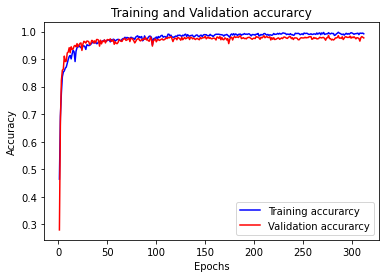

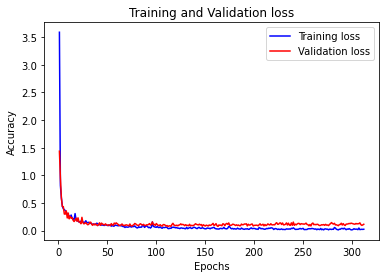

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights.h5')

In [19]:
#Results on test data
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights.h5')
from sklearn.metrics import classification_report
y_pred = saved_model.predict((X_test,W_test), batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

32/32 [==============================] - 4s 132ms/step
[4 4 4 ... 2 4 2]
[4 4 4 ... 2 4 2]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       263
           1       1.00      0.71      0.83        28
           2       0.97      0.97      0.97       523
           3       1.00      1.00      1.00       523
           4       0.98      0.99      0.98       680

    accuracy                           0.98      2017
   macro avg       0.98      0.92      0.95      2017
weighted avg       0.98      0.98      0.98      2017



In [40]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights.h5')

score,accuracy,precision,recall = saved_model.evaluate((X_train,W_train),y_train,verbose=1)

#score,accuracy,precision,recall = model.evaluate((X_train,W_train),y_train,verbose=1)
print("Train loss is {}".format(score))
print("Train accuracy is {}".format(accuracy))
print("Train Precision is {}".format(precision))
print("Train Recall is {}".format(recall))
f1 = (2*(precision*recall))/(precision+recall)
print("Train f1_score is {}".format(f1))

190/190 [==============================] - 11s 55ms/step - loss: 0.0192 - accuracy: 0.9969 - precision_1: 0.9969 - recall_1: 0.9967
Train loss is 0.01921253465116024
Train accuracy is 0.9968600273132324
Train Precision is 0.9968594908714294
Train Recall is 0.9966947436332703
Train f1_score is 0.9967771104449974


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 60, 128)  9728        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 30, 128)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 30, 30, 128)  0           max_pooling2d[0][0]              
_______________________________________________________________________________________

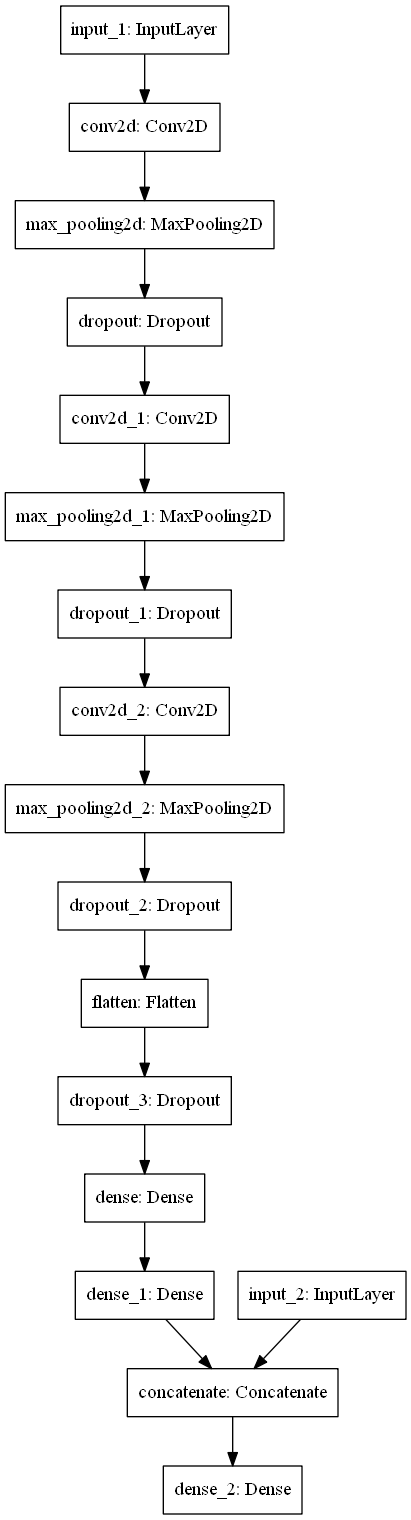

In [6]:
#Build the model
visible1 = Input(shape=(64,64,3))
#visible1 = Input(shape=(100,100,1))
# first feature extractor

conv1 = Conv2D(128, kernel_size=(5,5), activation='relu')(visible1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
dropout1=Dropout(0.2)(pool1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout1)
#conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout2=Dropout(0.2)(pool2)

conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout2)
#conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout3=Dropout(0.2)(pool3)


flat1 = Flatten()(dropout3)
dropout4=Dropout(0.5)(flat1)
#### New entry to try concatentation
flat2 = Input(shape=(1))



#hidden1 = Dense(64, activation='relu')(merge)
hidden1 = Dense(64, activation='relu')(dropout4)
hidden2 = Dense(16, activation='relu')(hidden1)

hidden3 = Concatenate()([hidden2, flat2])
#regress=

## 

#output = Dense(5, activation='softmax')(hidden2)

output = Dense(5, activation='softmax')(hidden3)

model = Model(inputs=(visible1,flat2), outputs=output)
#model = Model(inputs=(visible1), outputs=output)
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [7]:
#Compile models with hyperparameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],
             )

In [8]:
#Run model with 100 epochs
import time
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
start = time.perf_counter()
print(y_train.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_color_weights_100.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit((X_train,W_train), y_train, batch_size=64, epochs=100, validation_split=0.2,shuffle=1, callbacks=[es, mc], class_weight=None)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(6051, 5)
Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 3.0569 - accuracy: 0.1324 - precision: 0.1156 - recall: 0.0442
Epoch 00001: val_accuracy improved from -inf to 0.12304, saving model to best_model_color_weights_100.h5
76/76 [==============================] - 44s 575ms/step - loss: 3.0569 - accuracy: 0.1324 - precision: 0.1156 - recall: 0.0442 - val_loss: 1.9913 - val_accuracy: 0.1230 - val_precision: 0.1979 - val_recall: 0.0768
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 1.5486 - accuracy: 0.2535 - precision: 0.3016 - recall: 0.0674
Epoch 00002: val_accuracy improved from 0.12304 to 0.21140, saving model to best_model_color_weights_100.h5
76/76 [==============================] - 44s 581ms/step - loss: 1.5486 - accuracy: 0.2535 - precision: 0.3016 - recall: 0.0674 - val_loss: 1.6069 - val_accuracy: 0.2114 - val_precision: 0.3249 - val_recall: 0.0958
Epoch 3/100
76/76 [==============================] - ETA: 0s - loss: 1.3277 - accurac

Epoch 20/100
76/76 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.9395 - precision: 0.9433 - recall: 0.9376
Epoch 00020: val_accuracy did not improve from 0.95128
76/76 [==============================] - 40s 533ms/step - loss: 0.1807 - accuracy: 0.9395 - precision: 0.9433 - recall: 0.9376 - val_loss: 0.1934 - val_accuracy: 0.9405 - val_precision: 0.9435 - val_recall: 0.9381
Epoch 21/100
76/76 [==============================] - ETA: 0s - loss: 0.2041 - accuracy: 0.9347 - precision: 0.9387 - recall: 0.9302
Epoch 00021: val_accuracy did not improve from 0.95128
76/76 [==============================] - 51s 669ms/step - loss: 0.2041 - accuracy: 0.9347 - precision: 0.9387 - recall: 0.9302 - val_loss: 0.1659 - val_accuracy: 0.9513 - val_precision: 0.9544 - val_recall: 0.9513
Epoch 22/100
76/76 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9397 - precision: 0.9421 - recall: 0.9349
Epoch 00022: val_accuracy did not improve from 0.95128
76/76 [=

Epoch 40/100
76/76 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.9645 - precision: 0.9654 - recall: 0.9624
Epoch 00040: val_accuracy did not improve from 0.96697
76/76 [==============================] - 91s 1s/step - loss: 0.1071 - accuracy: 0.9645 - precision: 0.9654 - recall: 0.9624 - val_loss: 0.1062 - val_accuracy: 0.9628 - val_precision: 0.9644 - val_recall: 0.9628
Epoch 41/100
76/76 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.9591 - precision: 0.9608 - recall: 0.9570
Epoch 00041: val_accuracy did not improve from 0.96697
76/76 [==============================] - 93s 1s/step - loss: 0.1243 - accuracy: 0.9591 - precision: 0.9608 - recall: 0.9570 - val_loss: 0.1133 - val_accuracy: 0.9604 - val_precision: 0.9611 - val_recall: 0.9595
Epoch 42/100
76/76 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9636 - precision: 0.9672 - recall: 0.9618
Epoch 00042: val_accuracy improved from 0.96697 to 0.96780, saving mo

Epoch 60/100
76/76 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9725 - precision: 0.9749 - recall: 0.9711
Epoch 00060: val_accuracy did not improve from 0.97523
76/76 [==============================] - 71s 932ms/step - loss: 0.0890 - accuracy: 0.9725 - precision: 0.9749 - recall: 0.9711 - val_loss: 0.1004 - val_accuracy: 0.9678 - val_precision: 0.9677 - val_recall: 0.9653
Epoch 61/100
76/76 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9762 - precision: 0.9782 - recall: 0.9750
Epoch 00061: val_accuracy improved from 0.97523 to 0.97936, saving model to best_model_color_weights_100.h5
76/76 [==============================] - 71s 940ms/step - loss: 0.0690 - accuracy: 0.9762 - precision: 0.9782 - recall: 0.9750 - val_loss: 0.0770 - val_accuracy: 0.9794 - val_precision: 0.9794 - val_recall: 0.9794
Epoch 62/100
76/76 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9775 - precision: 0.9781 - recall: 0.9762
Epoch 0006

76/76 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9839 - precision: 0.9847 - recall: 0.9837
Epoch 00100: val_accuracy did not improve from 0.98183
76/76 [==============================] - 72s 951ms/step - loss: 0.0488 - accuracy: 0.9839 - precision: 0.9847 - recall: 0.9837 - val_loss: 0.0844 - val_accuracy: 0.9761 - val_precision: 0.9768 - val_recall: 0.9752
Elapsed 7047.800 seconds.


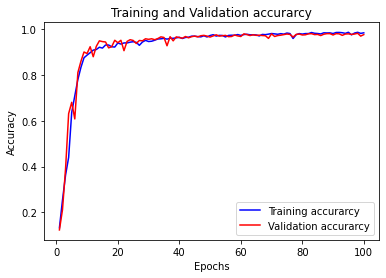

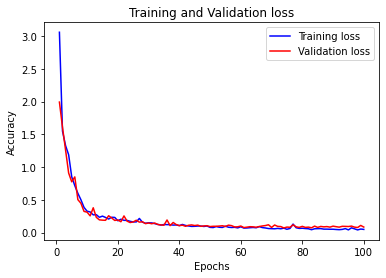

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
#Results on test data
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_100.h5')
y_pred = saved_model.predict((X_test,W_test), batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

32/32 [==============================] - 4s 119ms/step
[4 4 4 ... 2 4 2]
[4 4 4 ... 2 4 2]
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       263
           1       0.96      0.79      0.86        28
           2       0.98      0.94      0.96       523
           3       0.99      1.00      1.00       523
           4       0.98      0.99      0.99       680

    accuracy                           0.97      2017
   macro avg       0.96      0.94      0.95      2017
weighted avg       0.97      0.97      0.97      2017



In [33]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_100.h5')

#score,accuracy,precision,recall = saved_model.evaluate(X_test,y_test,verbose=1)

score,accuracy,precision,recall = saved_model.evaluate((X_train,W_train),y_train,verbose=1)
print("Train loss is {}".format(score))
print("Train accuracy is {}".format(accuracy))
print("Train Precision is {}".format(precision))
print("Train Recall is {}".format(recall))
f1 = (2*(precision*recall))/(precision+recall)
print("Train f1_score is {}".format(f1))

190/190 [==============================] - 10s 51ms/step - loss: 0.0288 - accuracy: 0.9937 - precision: 0.9942 - recall: 0.9934 1s - loss: 0.0204 - accuracy: 0.9957 - precision: 0.9
Train loss is 0.028805114328861237
Train accuracy is 0.9937200546264648
Train Precision is 0.9942110776901245
Train Recall is 0.9933895468711853
Train f1_score is 0.9938001424998453


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 60, 60, 128)  9728        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 30, 30, 128)  0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 30, 30, 128)  0           max_pooling2d_3[0][0]            
_______________________________________________________________________________________

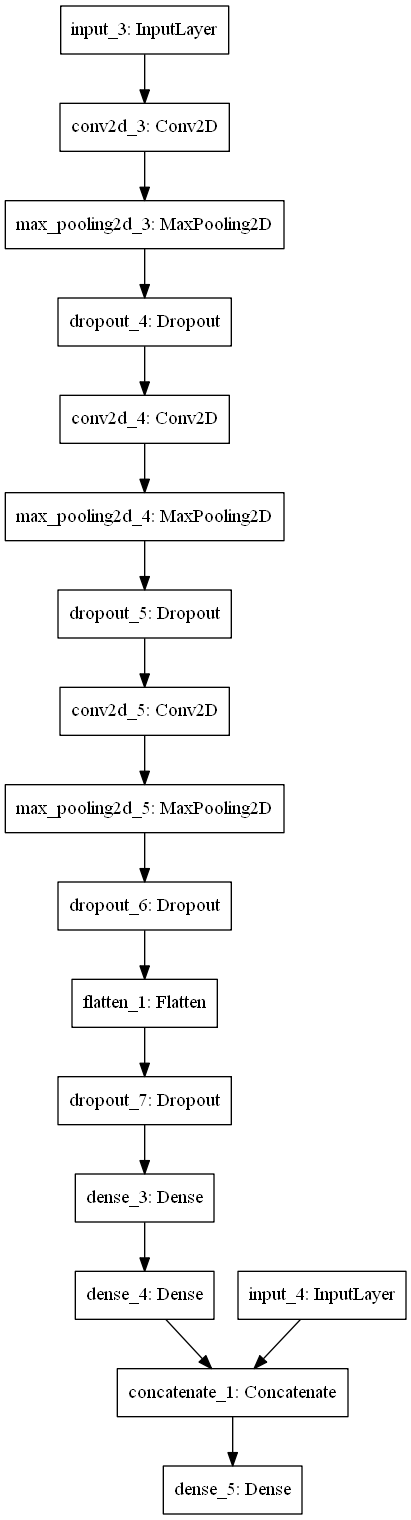

In [11]:
#Build the model
visible1 = Input(shape=(64,64,3))
#visible1 = Input(shape=(100,100,1))
# first feature extractor

conv1 = Conv2D(128, kernel_size=(5,5), activation='relu')(visible1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
dropout1=Dropout(0.2)(pool1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout1)
#conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout2=Dropout(0.2)(pool2)

conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout2)
#conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout3=Dropout(0.2)(pool3)


flat1 = Flatten()(dropout3)
dropout4=Dropout(0.5)(flat1)
#### New entry to try concatentation
flat2 = Input(shape=(1))



#hidden1 = Dense(64, activation='relu')(merge)
hidden1 = Dense(64, activation='relu')(dropout4)
hidden2 = Dense(16, activation='relu')(hidden1)

hidden3 = Concatenate()([hidden2, flat2])
#regress=

## 

#output = Dense(5, activation='softmax')(hidden2)

output = Dense(5, activation='softmax')(hidden3)

model = Model(inputs=(visible1,flat2), outputs=output)
#model = Model(inputs=(visible1), outputs=output)
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [12]:
#Compile models with hyperparameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],
             )

In [13]:
#Run model with 150 epochs
import time
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
start = time.perf_counter()
print(y_train.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_color_weights_150.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit((X_train,W_train), y_train, batch_size=64, epochs=150, validation_split=0.2,shuffle=1, callbacks=[es, mc], class_weight=None)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(6051, 5)
Epoch 1/150
76/76 [==============================] - ETA: 0s - loss: 3.4037 - accuracy: 0.2562 - precision_1: 0.1825 - recall_1: 0.1368
Epoch 00001: val_accuracy improved from -inf to 0.32618, saving model to best_model_color_weights_150.h5
76/76 [==============================] - 79s 1s/step - loss: 3.4037 - accuracy: 0.2562 - precision_1: 0.1825 - recall_1: 0.1368 - val_loss: 1.7584 - val_accuracy: 0.3262 - val_precision_1: 0.1919 - val_recall_1: 0.0628
Epoch 2/150
76/76 [==============================] - ETA: 0s - loss: 1.3452 - accuracy: 0.5223 - precision_1: 0.4611 - recall_1: 0.2118
Epoch 00002: val_accuracy improved from 0.32618 to 0.53344, saving model to best_model_color_weights_150.h5
76/76 [==============================] - 71s 940ms/step - loss: 1.3452 - accuracy: 0.5223 - precision_1: 0.4611 - recall_1: 0.2118 - val_loss: 1.0538 - val_accuracy: 0.5334 - val_precision_1: 0.9659 - val_recall_1: 0.1635
Epoch 3/150
76/76 [==============================] - ETA: 0s - l

Epoch 20/150
76/76 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9405 - precision_1: 0.9435 - recall_1: 0.9376
Epoch 00020: val_accuracy did not improve from 0.96614
76/76 [==============================] - 72s 946ms/step - loss: 0.1720 - accuracy: 0.9405 - precision_1: 0.9435 - recall_1: 0.9376 - val_loss: 0.1323 - val_accuracy: 0.9612 - val_precision_1: 0.9611 - val_recall_1: 0.9587
Epoch 21/150
76/76 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9351 - precision_1: 0.9390 - recall_1: 0.9314
Epoch 00021: val_accuracy did not improve from 0.96614
76/76 [==============================] - 72s 947ms/step - loss: 0.1868 - accuracy: 0.9351 - precision_1: 0.9390 - recall_1: 0.9314 - val_loss: 0.1196 - val_accuracy: 0.9628 - val_precision_1: 0.9643 - val_recall_1: 0.9604
Epoch 22/150
76/76 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9459 - precision_1: 0.9481 - recall_1: 0.9436
Epoch 00022: val_accuracy did not i

Epoch 59/150
76/76 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9663 - precision_1: 0.9679 - recall_1: 0.9653
Epoch 00059: val_accuracy did not improve from 0.98266
76/76 [==============================] - 75s 984ms/step - loss: 0.0987 - accuracy: 0.9663 - precision_1: 0.9679 - recall_1: 0.9653 - val_loss: 0.0814 - val_accuracy: 0.9752 - val_precision_1: 0.9776 - val_recall_1: 0.9744
Epoch 60/150
76/76 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9736 - precision_1: 0.9748 - recall_1: 0.9731
Epoch 00060: val_accuracy did not improve from 0.98266
76/76 [==============================] - 74s 972ms/step - loss: 0.0790 - accuracy: 0.9736 - precision_1: 0.9748 - recall_1: 0.9731 - val_loss: 0.1142 - val_accuracy: 0.9653 - val_precision_1: 0.9677 - val_recall_1: 0.9637
Epoch 61/150
76/76 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.9690 - precision_1: 0.9709 - recall_1: 0.9667
Epoch 00061: val_accuracy did not i

Epoch 79/150
76/76 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9812 - precision_1: 0.9820 - recall_1: 0.9802
Epoch 00079: val_accuracy did not improve from 0.98348
76/76 [==============================] - 75s 981ms/step - loss: 0.0542 - accuracy: 0.9812 - precision_1: 0.9820 - recall_1: 0.9802 - val_loss: 0.0658 - val_accuracy: 0.9777 - val_precision_1: 0.9777 - val_recall_1: 0.9761
Epoch 80/150
76/76 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9831 - precision_1: 0.9833 - recall_1: 0.9824
Epoch 00080: val_accuracy did not improve from 0.98348
76/76 [==============================] - 74s 974ms/step - loss: 0.0559 - accuracy: 0.9831 - precision_1: 0.9833 - recall_1: 0.9824 - val_loss: 0.0722 - val_accuracy: 0.9769 - val_precision_1: 0.9777 - val_recall_1: 0.9761
Epoch 81/150
76/76 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9787 - precision_1: 0.9789 - recall_1: 0.9779
Epoch 00081: val_accuracy did not i

Epoch 99/150
76/76 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9715 - precision_1: 0.9723 - recall_1: 0.9709
Epoch 00099: val_accuracy did not improve from 0.98348
76/76 [==============================] - 75s 986ms/step - loss: 0.0901 - accuracy: 0.9715 - precision_1: 0.9723 - recall_1: 0.9709 - val_loss: 0.0810 - val_accuracy: 0.9769 - val_precision_1: 0.9793 - val_recall_1: 0.9761
Epoch 100/150
76/76 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9862 - precision_1: 0.9868 - recall_1: 0.9849
Epoch 00100: val_accuracy did not improve from 0.98348
76/76 [==============================] - 74s 975ms/step - loss: 0.0466 - accuracy: 0.9862 - precision_1: 0.9868 - recall_1: 0.9849 - val_loss: 0.0661 - val_accuracy: 0.9785 - val_precision_1: 0.9785 - val_recall_1: 0.9785
Epoch 101/150
76/76 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9853 - precision_1: 0.9859 - recall_1: 0.9853
Epoch 00101: val_accuracy did not

Epoch 119/150
76/76 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9868 - precision_1: 0.9872 - recall_1: 0.9860
Epoch 00119: val_accuracy did not improve from 0.98679
76/76 [==============================] - 74s 977ms/step - loss: 0.0413 - accuracy: 0.9868 - precision_1: 0.9872 - recall_1: 0.9860 - val_loss: 0.0805 - val_accuracy: 0.9761 - val_precision_1: 0.9768 - val_recall_1: 0.9752
Epoch 120/150
76/76 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9849 - precision_1: 0.9851 - recall_1: 0.9843
Epoch 00120: val_accuracy did not improve from 0.98679
76/76 [==============================] - 75s 987ms/step - loss: 0.0389 - accuracy: 0.9849 - precision_1: 0.9851 - recall_1: 0.9843 - val_loss: 0.0863 - val_accuracy: 0.9769 - val_precision_1: 0.9793 - val_recall_1: 0.9744
Epoch 121/150
76/76 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9835 - precision_1: 0.9845 - recall_1: 0.9824
Epoch 00121: val_accuracy did no

Epoch 139/150
76/76 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9886 - precision_1: 0.9886 - recall_1: 0.9876
Epoch 00139: val_accuracy did not improve from 0.98679
76/76 [==============================] - 74s 977ms/step - loss: 0.0332 - accuracy: 0.9886 - precision_1: 0.9886 - recall_1: 0.9876 - val_loss: 0.0581 - val_accuracy: 0.9851 - val_precision_1: 0.9851 - val_recall_1: 0.9851
Epoch 140/150
76/76 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9895 - precision_1: 0.9897 - recall_1: 0.9888
Epoch 00140: val_accuracy did not improve from 0.98679
76/76 [==============================] - 75s 980ms/step - loss: 0.0317 - accuracy: 0.9895 - precision_1: 0.9897 - recall_1: 0.9888 - val_loss: 0.1257 - val_accuracy: 0.9579 - val_precision_1: 0.9594 - val_recall_1: 0.9571
Epoch 141/150
76/76 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9851 - precision_1: 0.9857 - recall_1: 0.9847
Epoch 00141: val_accuracy did no

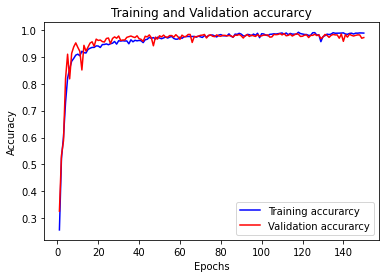

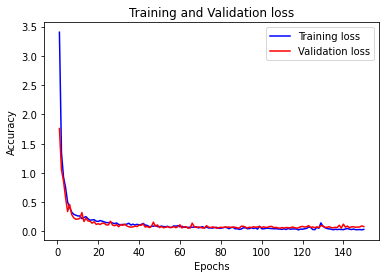

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
#Results on test data
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_150.h5')
from sklearn.metrics import classification_report
y_pred = saved_model.predict((X_test,W_test), batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

32/32 [==============================] - 4s 124ms/step
[4 4 4 ... 2 4 2]
[4 4 4 ... 2 4 2]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       263
           1       1.00      0.82      0.90        28
           2       0.97      0.98      0.97       523
           3       1.00      1.00      1.00       523
           4       0.99      0.99      0.99       680

    accuracy                           0.98      2017
   macro avg       0.98      0.95      0.96      2017
weighted avg       0.98      0.98      0.98      2017



In [12]:
#prediction = keras.utils.np_utils.probas_to_classes(self.model_comp.predict(X))
prediction = saved_model.predict((X,W))[:,1].tolist()
print(len(prediction))

8068


In [15]:
prediction__class = np.argmax(saved_model.predict((X,W)), axis=-1)
print(prediction__class)

[0 0 0 ... 4 4 4]


In [16]:
df = pd.read_csv("E:/Meat_Excels/MeatCutPredictions.csv")
df["Colour_Predition_Weight"] = prediction__class

In [17]:
df.to_csv("E:/Meat_Excels/MeatCutPredictions.csv")

In [24]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_150.h5')

#score,accuracy,precision,recall = saved_model.evaluate(X_test,y_test,verbose=1)

score,accuracy,precision,recall = saved_model.evaluate((X_train,W_train),y_train,verbose=1)
print("Train loss is {}".format(score))
print("Train accuracy is {}".format(accuracy))
print("Train Precision is {}".format(precision))
print("Train Recall is {}".format(recall))
f1 = (2*(precision*recall))/(precision+recall)
print("Train f1_score is {}".format(f1))

190/190 [==============================] - 14s 71ms/step - loss: 0.0182 - accuracy: 0.9959 - precision_1: 0.9964 - recall_1: 0.9957
Train loss is 0.018155042082071304
Train accuracy is 0.995868444442749
Train Precision is 0.9963618516921997
Train Recall is 0.9957031607627869
Train f1_score is 0.9960323973269961


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 60, 60, 128)  9728        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 30, 30, 128)  0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 30, 30, 128)  0           max_pooling2d_6[0][0]            
_______________________________________________________________________________________

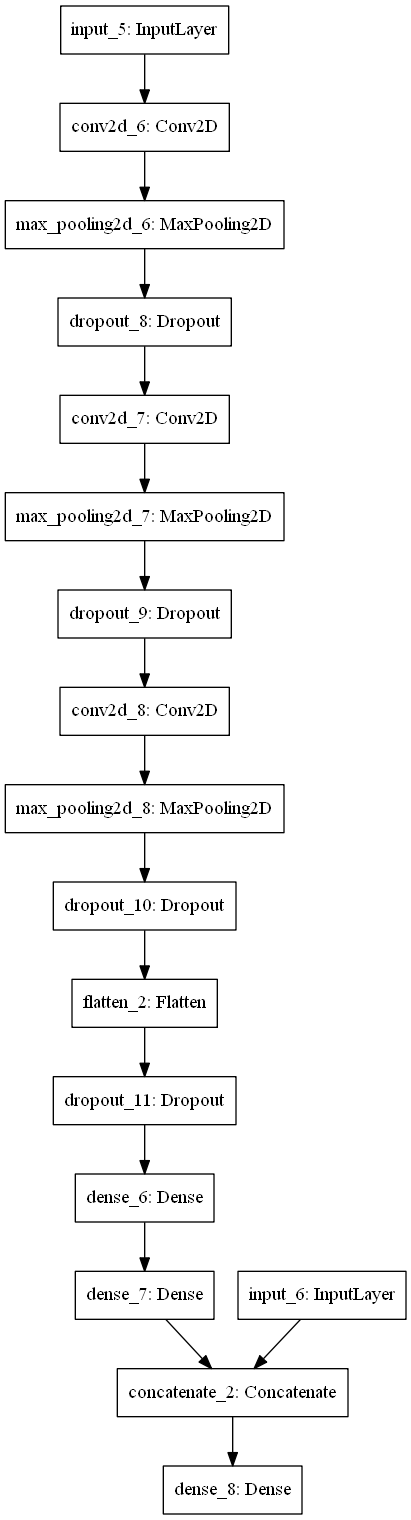

In [16]:
#Build the model
visible1 = Input(shape=(64,64,3))
#visible1 = Input(shape=(100,100,1))
# first feature extractor

conv1 = Conv2D(128, kernel_size=(5,5), activation='relu')(visible1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
dropout1=Dropout(0.2)(pool1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout1)
#conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout2=Dropout(0.2)(pool2)

conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout2)
#conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout3=Dropout(0.2)(pool3)


flat1 = Flatten()(dropout3)
dropout4=Dropout(0.5)(flat1)
#### New entry to try concatentation
flat2 = Input(shape=(1))



#hidden1 = Dense(64, activation='relu')(merge)
hidden1 = Dense(64, activation='relu')(dropout4)
hidden2 = Dense(16, activation='relu')(hidden1)

hidden3 = Concatenate()([hidden2, flat2])
#regress=

## 

#output = Dense(5, activation='softmax')(hidden2)

output = Dense(5, activation='softmax')(hidden3)

model = Model(inputs=(visible1,flat2), outputs=output)
#model = Model(inputs=(visible1), outputs=output)
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [17]:
#Compile models with hyperparameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],
             )

In [18]:
#Run model with 50 epochs
import time
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
start = time.perf_counter()
print(y_train.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_color_weights_50.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit((X_train,W_train), y_train, batch_size=64, epochs=50, validation_split=0.2,shuffle=1, callbacks=[es, mc], class_weight=None)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(6051, 5)
Epoch 1/50
76/76 [==============================] - ETA: 0s - loss: 2.8610 - accuracy: 0.2750 - precision_2: 0.2925 - recall_2: 0.1614
Epoch 00001: val_accuracy improved from -inf to 0.43353, saving model to best_model_color_weights_50.h5
76/76 [==============================] - 76s 1s/step - loss: 2.8610 - accuracy: 0.2750 - precision_2: 0.2925 - recall_2: 0.1614 - val_loss: 1.4305 - val_accuracy: 0.4335 - val_precision_2: 0.5224 - val_recall_2: 0.3080
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 1.0113 - accuracy: 0.5209 - precision_2: 0.6273 - recall_2: 0.3874
Epoch 00002: val_accuracy improved from 0.43353 to 0.55078, saving model to best_model_color_weights_50.h5
76/76 [==============================] - 75s 988ms/step - loss: 1.0113 - accuracy: 0.5209 - precision_2: 0.6273 - recall_2: 0.3874 - val_loss: 0.9145 - val_accuracy: 0.5508 - val_precision_2: 0.7852 - val_recall_2: 0.3774
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 

Epoch 20/50
76/76 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9349 - precision_2: 0.9402 - recall_2: 0.9289
Epoch 00020: val_accuracy did not improve from 0.94963
76/76 [==============================] - 40s 532ms/step - loss: 0.2039 - accuracy: 0.9349 - precision_2: 0.9402 - recall_2: 0.9289 - val_loss: 0.1852 - val_accuracy: 0.9430 - val_precision_2: 0.9476 - val_recall_2: 0.9405
Epoch 21/50
76/76 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9229 - precision_2: 0.9315 - recall_2: 0.9153
Epoch 00021: val_accuracy did not improve from 0.94963
76/76 [==============================] - 40s 531ms/step - loss: 0.2450 - accuracy: 0.9229 - precision_2: 0.9315 - recall_2: 0.9153 - val_loss: 0.2257 - val_accuracy: 0.9240 - val_precision_2: 0.9283 - val_recall_2: 0.9191
Epoch 22/50
76/76 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.9312 - precision_2: 0.9359 - recall_2: 0.9256
Epoch 00022: val_accuracy did not impr

Epoch 40/50
76/76 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9583 - precision_2: 0.9596 - recall_2: 0.9558
Epoch 00040: val_accuracy did not improve from 0.96201
76/76 [==============================] - 41s 536ms/step - loss: 0.1312 - accuracy: 0.9583 - precision_2: 0.9596 - recall_2: 0.9558 - val_loss: 0.1443 - val_accuracy: 0.9463 - val_precision_2: 0.9461 - val_recall_2: 0.9422
Epoch 41/50
76/76 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9564 - precision_2: 0.9584 - recall_2: 0.9525
Epoch 00041: val_accuracy did not improve from 0.96201
76/76 [==============================] - 40s 530ms/step - loss: 0.1300 - accuracy: 0.9564 - precision_2: 0.9584 - recall_2: 0.9525 - val_loss: 0.1388 - val_accuracy: 0.9604 - val_precision_2: 0.9610 - val_recall_2: 0.9571
Epoch 42/50
76/76 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9589 - precision_2: 0.9620 - recall_2: 0.9579
Epoch 00042: val_accuracy improved fro

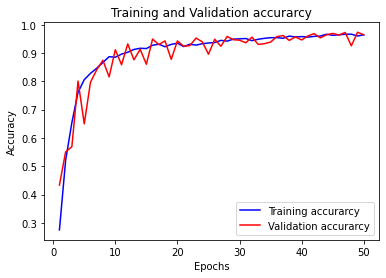

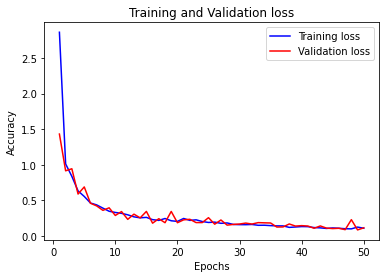

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
#Results on test data
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_50.h5')
y_pred = saved_model.predict((X_test,W_test), batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

32/32 [==============================] - 4s 121ms/step
[4 4 4 ... 2 4 2]
[4 4 4 ... 2 4 2]
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       263
           1       0.72      0.75      0.74        28
           2       0.96      0.97      0.96       523
           3       0.99      1.00      1.00       523
           4       0.99      0.97      0.98       680

    accuracy                           0.97      2017
   macro avg       0.92      0.92      0.92      2017
weighted avg       0.97      0.97      0.97      2017



In [37]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_50.h5')

#score,accuracy,precision,recall = saved_model.evaluate(X_test,y_test,verbose=1)

score,accuracy,precision,recall = saved_model.evaluate((X_train,W_train),y_train,verbose=1)
print("train loss is {}".format(score))
print("train accuracy is {}".format(accuracy))
print("train Precision is {}".format(precision))
print("train Recall is {}".format(recall))
f1 = (2*(precision*recall))/(precision+recall)
print("train f1_score is {}".format(f1))

190/190 [==============================] - 9s 50ms/step - loss: 0.0568 - accuracy: 0.9846 - precision_2: 0.9849 - recall_2: 0.9840
train loss is 0.056795284152030945
train accuracy is 0.9846306443214417
train Precision is 0.9849462509155273
train Recall is 0.9839695692062378
train f1_score is 0.9844576678191495


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 60, 128)  9728        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 30, 128)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 30, 30, 128)  0           max_pooling2d[0][0]              
_______________________________________________________________________________________

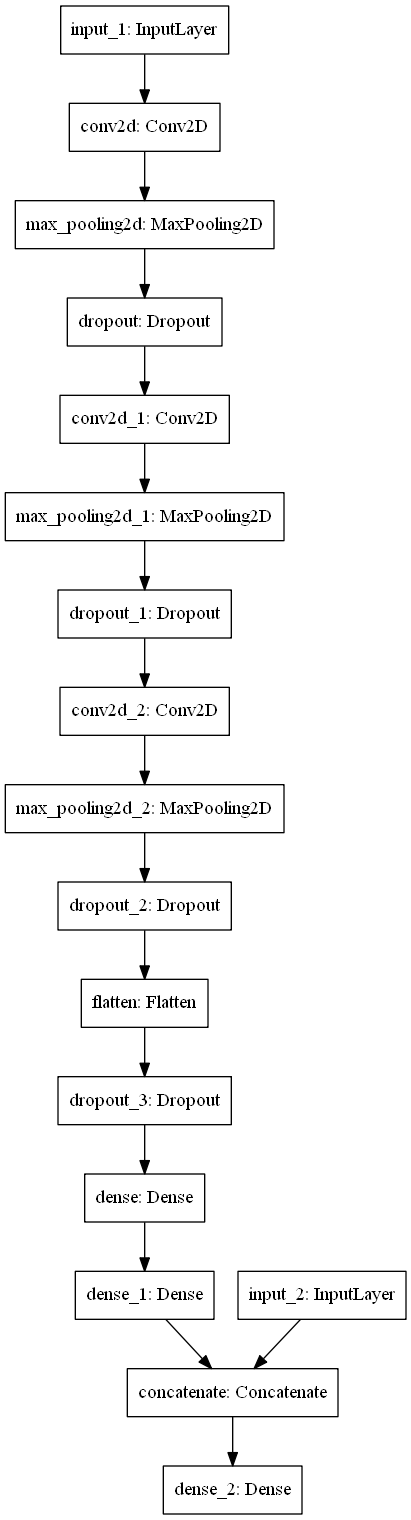

In [8]:
#Build the model
visible1 = Input(shape=(64,64,3))
#visible1 = Input(shape=(100,100,1))
# first feature extractor

conv1 = Conv2D(128, kernel_size=(5,5), activation='relu')(visible1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
dropout1=Dropout(0.2)(pool1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout1)
#conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout2=Dropout(0.2)(pool2)

conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout2)
#conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout3=Dropout(0.2)(pool3)


flat1 = Flatten()(dropout3)
dropout4=Dropout(0.5)(flat1)
#### New entry to try concatentation
flat2 = Input(shape=(1))



#hidden1 = Dense(64, activation='relu')(merge)
hidden1 = Dense(64, activation='relu')(dropout4)
hidden2 = Dense(16, activation='relu')(hidden1)

hidden3 = Concatenate()([hidden2, flat2])
#regress=

## 

#output = Dense(5, activation='softmax')(hidden2)

output = Dense(5, activation='softmax')(hidden3)

model = Model(inputs=(visible1,flat2), outputs=output)
#model = Model(inputs=(visible1), outputs=output)
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [22]:
#Compile models with hyperparameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],
             )

In [23]:
#Run model with 25 epochs
import time
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
start = time.perf_counter()
print(y_train.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_color_weights_25.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit((X_train,W_train), y_train, batch_size=64, epochs=25, validation_split=0.2,shuffle=1, callbacks=[es, mc], class_weight=None)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(6051, 5)
Epoch 1/25
76/76 [==============================] - ETA: 0s - loss: 4.2658 - accuracy: 0.2543 - precision_3: 0.2586 - recall_3: 0.1318
Epoch 00001: val_accuracy improved from -inf to 0.38563, saving model to best_model_color_weights_25.h5
76/76 [==============================] - 41s 540ms/step - loss: 4.2658 - accuracy: 0.2543 - precision_3: 0.2586 - recall_3: 0.1318 - val_loss: 2.1371 - val_accuracy: 0.3856 - val_precision_3: 0.1674 - val_recall_3: 0.0595
Epoch 2/25
76/76 [==============================] - ETA: 0s - loss: 1.3516 - accuracy: 0.4857 - precision_3: 0.5394 - recall_3: 0.2091
Epoch 00002: val_accuracy improved from 0.38563 to 0.45169, saving model to best_model_color_weights_25.h5
76/76 [==============================] - 41s 533ms/step - loss: 1.3516 - accuracy: 0.4857 - precision_3: 0.5394 - recall_3: 0.2091 - val_loss: 1.2948 - val_accuracy: 0.4517 - val_precision_3: 0.6728 - val_recall_3: 0.2428
Epoch 3/25
76/76 [==============================] - ETA: 0s - los

Epoch 20/25
76/76 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9312 - precision_3: 0.9357 - recall_3: 0.9262
Epoch 00020: val_accuracy did not improve from 0.92486
76/76 [==============================] - 41s 534ms/step - loss: 0.1939 - accuracy: 0.9312 - precision_3: 0.9357 - recall_3: 0.9262 - val_loss: 0.3083 - val_accuracy: 0.8588 - val_precision_3: 0.8679 - val_recall_3: 0.8464
Epoch 21/25
76/76 [==============================] - ETA: 0s - loss: 0.1892 - accuracy: 0.9329 - precision_3: 0.9384 - recall_3: 0.9283
Epoch 00021: val_accuracy did not improve from 0.92486
76/76 [==============================] - 40s 525ms/step - loss: 0.1892 - accuracy: 0.9329 - precision_3: 0.9384 - recall_3: 0.9283 - val_loss: 0.2259 - val_accuracy: 0.9166 - val_precision_3: 0.9246 - val_recall_3: 0.9108
Epoch 22/25
76/76 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9428 - precision_3: 0.9463 - recall_3: 0.9386
Epoch 00022: val_accuracy did not impr

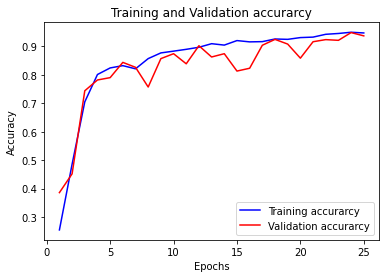

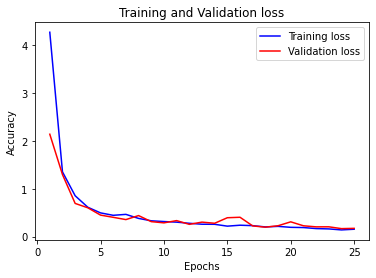

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
#Results on test data
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_25.h5')
from sklearn.metrics import classification_report
y_pred = saved_model.predict((X_test,W_test), batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

32/32 [==============================] - 5s 143ms/step
[4 4 4 ... 2 4 2]
[4 4 4 ... 2 4 2]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       263
           1       0.92      0.39      0.55        28
           2       0.99      0.86      0.92       523
           3       1.00      1.00      1.00       523
           4       0.95      0.99      0.97       680

    accuracy                           0.95      2017
   macro avg       0.93      0.84      0.86      2017
weighted avg       0.95      0.95      0.94      2017



In [38]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_25.h5')

#score,accuracy,precision,recall = saved_model.evaluate(X_test,y_test,verbose=1)

score,accuracy,precision,recall = saved_model.evaluate((X_train,W_train),y_train,verbose=1)
print("train loss is {}".format(score))
print("train accuracy is {}".format(accuracy))
print("train Precision is {}".format(precision))
print("train Recall is {}".format(recall))
f1 = (2*(precision*recall))/(precision+recall)
print("train f1_score is {}".format(f1))

190/190 [==============================] - 9s 47ms/step - loss: 0.1332 - accuracy: 0.9547 - precision_3: 0.9613 - recall_3: 0.9479
train loss is 0.13318605720996857
train accuracy is 0.9547182321548462
train Precision is 0.9612870812416077
train Recall is 0.9479424953460693
train f1_score is 0.9545681522122202


In [6]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights.h5')

In [ ]:
import pandas as pd
df = pd.read_csv("E:/Meat_Excels/MeatCutPredictions.csv")
df["Colour_Predition_1000_weights"] = prediction__class

In [13]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_100.h5')

In [ ]:
import pandas as pd
df = pd.read_csv("E:/Meat_Excels/MeatCutPredictions.csv")
df["Colour_Predition_100_weights"] = prediction__class

In [ ]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_150.h5')

In [ ]:
prediction__class = np.argmax(saved_model.predict(X), axis=-1)
print(prediction__class)

In [ ]:
import pandas as pd
df = pd.read_csv("E:/Meat_Excels/MeatCutPredictions.csv")
df["Colour_Predition_150_weights"] = prediction__class

In [ ]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_50.h5')

In [ ]:
prediction__class = np.argmax(saved_model.predict(X), axis=-1)
print(prediction__class)

In [ ]:
import pandas as pd
df = pd.read_csv("E:/Meat_Excels/MeatCutPredictions.csv")
df["Colour_Predition_50_weights"] = prediction__class

In [ ]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_color_weights_25.h5')

In [ ]:
prediction__class = np.argmax(saved_model.predict(X), axis=-1)
print(prediction__class)

In [ ]:
import pandas as pd
df = pd.read_csv("E:/Meat_Excels/MeatCutPredictions.csv")
df["Colour_Predition_25_weights"] = prediction__class